### Notes: ###

- recommended lda package (https://pypi.org/project/lda/) uses collapsed gibs sampling
    - but looks not so powerful
- recommended gensim libary uses online variational inference
    - looks good, install: https://visualstudio.microsoft.com/de/visual-cpp-build-tools/ to use it
    - Also pyLDAvis has the same problem..
      
- Therefore we currently use scikit learn. It uses online variational inference



# Topic modeling with latent Dirichlet allocation (LDA) 

We will study the Reuters-21578 document collection, which contains news wire articles.

First we download and load the Reuters-21578 dataset using the *Natural Language Toolkit* (*NLTK*), which is a platform for handling natural language in Python. It provides access to several text corpora and functions for handling text data.

In [8]:
import nltk
import numpy as np
from nltk.corpus import reuters
from sklearn.decomposition import LatentDirichletAllocation
nltk.download('reuters')
articles=[]
for doc_id in reuters.fileids():
    articles.append(reuters.raw(doc_id))

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!


The variable $articles$ now contains 10788 documents in the form of strings.

LDA is a bag-of-words model. This means that for performing inference with the LDA model, it suffices to know which words appear in a document and how often each word appears. Therefore we will pass the document collection as a document word frequency matrix. The document word frequency matrix is a 2D array where rows represent documents and columns represent words and each cell counts how many times the specific word appears in a given document.

The following code constructs a document word matrix $tf$, pruning the vocabulary of words such that it only contains words  that:

* have latin characters and are of length 3 or more characters (token_pattern='[a-zA-Z]{3,}'),

* are not english stop words, that is, frequent but uninformative words such as "the" or "a" (stop_words='english')

* occur in at least 0.2% of all documents and at most 70% of all documents (max_df=0.70, min_df=0.002)

and out of these using the 2000 most frequent words (max_features=2000).

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
tf = CountVectorizer( token_pattern='[a-zA-Z]{3,}',max_df=0.70, min_df=0.002,max_features=2000,stop_words='english')
articles_words = tf.fit_transform(articles)
word_index = tf.get_feature_names_out()

#### Doing the Latent Dirichlet Allocation
Using sklearn.decomposition.LatentDirichletAllocation, we trained a LDA model with varying number of topics on the document collection using the document word frequency matrix *articles_words*. The Dirichlet prior parameters $\alpha$ and $\eta$ are left at their default values of $1/K$. Multicore processing is turned on.
The perplexity is printed for each chosen configuration and we can then chose the best number of topics.

In [38]:
for nr_comp in [5,10,20,30,40,50,60,100]:
    lda_model = LatentDirichletAllocation(n_components=nr_comp, random_state=42, n_jobs=-1, max_iter=10)
    lda_model.fit(articles_words)
    
    perplexity = lda_model.perplexity(articles_words)
    print(f"Perplexity with {nr_comp} Topics: {perplexity}")

Perplexity with 5 Topics: 506.2631074264214
Perplexity with 10 Topics: 456.2587930213703
Perplexity with 20 Topics: 414.62708578839397
Perplexity with 30 Topics: 404.25149758610024
Perplexity with 40 Topics: 396.65100459245787
Perplexity with 50 Topics: 393.43710062244475
Perplexity with 60 Topics: 389.5353921598822
Perplexity with 100 Topics: 397.0614653253226


#### Hyperparameter Tuning
We use the GridSearchCV Module from sklearn to tune the hyperparameters $\alpha$ and $\eta$, here called doc_topic_prior and topic_word_prior. We also threw in our range of number of topics in there, to find the best parameter triplet.

In [14]:
from sklearn.model_selection import GridSearchCV
#doc_topic_prior == alpha
#topic_word_prior == eta
param_grid = {'doc_topic_prior': [0.01, 0.1, 1.0], 'topic_word_prior': [0.01, 0.1, 1.0], 'n_components':[20,30,40]}
grid_search = GridSearchCV(LatentDirichletAllocation(n_components=30, random_state=42, n_jobs=-1, max_iter=10), param_grid=param_grid, n_jobs=-1)
grid_search.fit(articles_words)
print(grid_search.best_params_)

{'doc_topic_prior': 0.1, 'n_components': 20, 'topic_word_prior': 0.1}


Here we train the LDA with our selected parameters and 10 times more iterations

In [15]:
#Train model with the selected parameters
lda_model = LatentDirichletAllocation(n_components=20, random_state=42, n_jobs=-1, max_iter=100, doc_topic_prior= 0.1, topic_word_prior=0.1)
lda_model.fit(articles_words)

LatentDirichletAllocation(doc_topic_prior=0.1, max_iter=100, n_components=20,
                          n_jobs=-1, random_state=42, topic_word_prior=0.1)

#### Each Topic Discribed in 10 Words
We described each topic by listing the 10 most probable words in that topic.

In [16]:
topic_word_distributions = lda_model.components_

# Display the top 10 words for each topic
for topic_idx, topic in enumerate(topic_word_distributions):
    top_words_indices = topic.argsort()[:-11:-1]  # Get indices of top 10 words
    top_words = [word_index[i] for i in top_words_indices]
    
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

Topic 1: said, government, foreign, trade, exports, year, canadian, canada, south, china
Topic 2: said, growth, analysts, year, economic, government, economy, market, policy, markets
Topic 3: oil, said, gas, prices, opec, mln, crude, energy, bpd, production
Topic 4: said, union, dlrs, spokesman, oil, plant, strike, today, crude, company
Topic 5: said, department, credit, usair, court, pacific, twa, air, dlrs, southern
Topic 6: bank, pct, rate, banks, market, said, money, rates, stg, today
Topic 7: mln, tonnes, production, year, nil, stocks, total, exports, week, imports
Topic 8: said, shares, pct, stock, company, offer, share, dlrs, common, group
Topic 9: dollar, said, yen, japan, west, currency, exchange, bank, german, baker
Topic 10: dlrs, said, mln, year, quarter, company, earnings, share, sales, expects
Topic 11: said, wheat, grain, soviet, usda, agriculture, corn, program, crop, farmers
Topic 12: said, trade, japan, states, japanese, united, officials, reagan, house, told
Topic 13

ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RIFT (top topic: 11)
CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STOCKS (top topic: 0)
JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWARDS (top topic: 2)
THAI TRADE DEFICIT WIDENS IN FIRST QUARTER (top topic: 19)
INDONESIA SEES CPO PRICE RISING SHARPLY (top topic: 2)
AUSTRALIAN FOREIGN SHIP BAN ENDS BUT NSW PORTS HIT (top topic: 3)
INDONESIAN COMMODITY EXCHANGE MAY EXPAND (top topic: 16)
SRI LANKA GETS USDA APPROVAL FOR WHEAT PRICE (top topic: 4)
WESTERN MINING TO OPEN NEW GOLD MINE IN AUSTRALIA (top topic: 15)
SUMITOMO BANK AIMS AT QUICK RECOVERY FROM MERGER (top topic: 1)


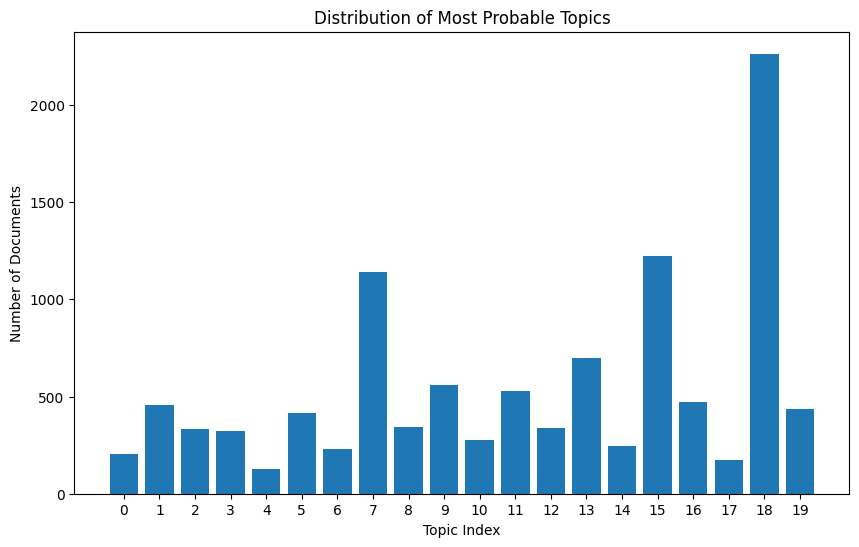

In [17]:
import matplotlib.pyplot as plt

topic_distribution = lda_model.transform(articles_words)
most_probable_topics = np.argmax(topic_distribution, axis=1)
topic_counts = np.bincount(most_probable_topics)

for i in range(10):
    print("{} (top topic: {})".format(articles[i].split("\n")[0], most_probable_topics[i]))

plt.figure(figsize=(10, 6))
plt.bar(range(len(topic_counts)), topic_counts, align='center')
plt.xlabel('Topic Index')
plt.ylabel('Number of Documents')
plt.title('Distribution of Most Probable Topics')
plt.xticks(range(len(topic_counts)))
plt.show()

#### Similarity between Documents
From the inferred topic distributions, we can define the topic distance between two documents $d_1$, $d_2$ to be the Kullback-Leibler divergence between their topic distributions. We implemented a function *get_similar(doc_id,doc_topic_distribution)* that takes an integer *doc_id* representing the document index and a matrix that gives the distribution over topics for each document. The function returns a list that contains the indices of all documents in the collection ordered by their topic distance to *doc_id*. 


In [18]:
def get_similar(doc_id, doc_topic_distribution):
    # Extract the topic distribution for the specified document
    theta_d1 = doc_topic_distribution[doc_id]
    
    # Calculate Kullback-Leibler divergence with all other documents
    kl_divergences = []
    for i, theta_d2 in enumerate(doc_topic_distribution):
        kl_divergence = np.sum(theta_d1 * np.log(theta_d1 / theta_d2))
        kl_divergences.append((i, kl_divergence))
    
    # Sort documents by their topic distance to doc_id
    sorted_documents = sorted(kl_divergences, key=lambda x: x[1])
    
    # Extract and return the indices of similar documents
    similar_documents_indices = [idx for idx, _ in sorted_documents]
    
    return similar_documents_indices

In [19]:
# lda.transform(X) gives a matrix of documents with their respective topic distribution
document_topic_dist = lda_model.transform(articles_words)
sim_ids_1 = get_similar(1, document_topic_dist)
print(sim_ids_1[:10])

[1, 5601, 7377, 2994, 1095, 8734, 1102, 7352, 10367, 6979]


In [22]:
print("ARTICLE 1\n\n",articles[1])
print("ARTICLE 5601\n\n",articles[5601])

ARTICLE 1

 CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STOCKS
  A survey of 19 provinces and seven cities
  showed vermin consume between seven and 12 pct of China's grain
  stocks, the China Daily said.
      It also said that each year 1.575 mln tonnes, or 25 pct, of
  China's fruit output are left to rot, and 2.1 mln tonnes, or up
  to 30 pct, of its vegetables. The paper blamed the waste on
  inadequate storage and bad preservation methods.
      It said the government had launched a national programme to
  reduce waste, calling for improved technology in storage and
  preservation, and greater production of additives. The paper
  gave no further details.
  


ARTICLE 5601

 AUSTRALIAN WHEAT EXPORTS RISE IN FEBRUARY
  Australian wheat shipments rose to
  1.33 mln tonnes in February from 1.01 mln in January, an
  Australian Wheat Board official said.
      February's shipments were down on the 1.54 mln tonnes
  shipped in February 1986.
      Cumulative shipments for the first five 